# Simulation of the Augmented system with Integral Action
---

The simulation can be performed in the Non-linear or the linear model of the system.  
Both include Torque steps on the wheels as disturbance but with the linearized model, sensor readings noise and little constants disturbances on the system states could be simulated. See the (System Simulation section). 

## Symbols Definitons
---

In [65]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt

#--- Model Parameters ---
d       = symbols('d',    real=True, positive=True)         # Distance between wheels
visc    = symbols('c_alpha',real=True)                      # Viscous, damping constant 
l       = symbols('l',    real=True, positive=True)         # Height of the COM
r       = symbols('r',    real=True, positive=True)         # Radius of the wheel
Mp      = symbols('M_p',  real=True, positive=True)         # Mass of the pendulum without the wheels
Mw      = symbols('M_w',  real=True, positive=True)         # Mass of each wheel
Iw_c    = symbols('I_wc',  real=True)                       # MOI wheel center
Iw_r    = symbols('I_wr',  real=True)                       # MOI wheel radial
Ip_x    = symbols('I_px',  real=True)                       # MOI pendulum x
Ip_y    = symbols('I_py',  real=True)                       # MOI pendulum y
Ip_z    = symbols('I_pz',  real=True)                       # MOI pendulum z

#--- Constants & Aux. variables ---
g = symbols('g', constant=True)                             # Gravity acceleration
t = symbols('t', real=True)                                 # Time

#--- State Variables ---
x           = symbols('x',  real=True)                      # Linear pos
pitch       = symbols('theta',  real=True)                  # Pitch angle
yaw         = symbols('psi',  real=True)                    # Yaw angle
x_vel       = Derivative(x,t)                               # Linear vel
pitch_vel   = Derivative(pitch,t)                           # Pitch vel
yaw_vel     = Derivative(yaw,t)                             # Yaw vel
x_acc       = Derivative(x_vel,t)                           # Linear acc
pitch_acc   = Derivative(pitch_vel,t)                       # Pitch acc
yaw_acc     = Derivative(yaw_vel,t)                         # Yaw acc

#--- Extra states for the Augmented system with Integral Action ---
err_x_vel   = symbols("e_x",  real=True)
err_yaw_vel = symbols("e_psi",  real=True)

#--- Inputs ---
Tl = symbols('T_L', real=True)                              # Torque of the left wheel
Tr = symbols('T_R', real=True)                              # Torque of the right wheel

#--- Extra inputs for the Augmented system with Integral Action ---
x_ref = symbols('r_x', real=True)
yaw_ref = symbols('r_psi', real=True)

## Defining all the matrices of the system
----------

In [66]:

#*--- Matrices for the 3 states model
M = Matrix([[Mp+2*Mw+2*Iw_c/r**2, Mp*l*cos(pitch) ,                                                                     0],
            [ Mp*l*cos(pitch)   , Ip_y+Mp*l**2    ,                                                                     0],
            [0                  ,                0, Ip_z+2*Iw_r+(Mw+Iw_c/r**2)*d**2/2-(Ip_z-Ip_x-Mp*l**2)*sin(pitch)**2  ]])

C = Matrix([[                      0, -Mp*l*pitch_vel*sin(pitch),                          -Mp*l*yaw_vel*sin(pitch)],
            [                      0,                          0, (Ip_z-Ip_x-Mp*l**2)*yaw_vel*sin(pitch)*cos(pitch)],
            [Mp*l*yaw_vel*sin(pitch), -(Ip_z-Ip_x-Mp*l**2)*yaw_vel*sin(pitch)*cos(pitch), -(Ip_z-Ip_x-Mp*l**2)*pitch_vel*sin(pitch)*cos(pitch)]])

D = Matrix([[2*visc/r**2, -2*visc/r, 0],
            [-2*visc/r, 2*visc, 0],
            [0, 0, (d**2/(2*r**2))*visc]])

B = Matrix([[     1/r,     1/r],
            [      -1,      -1],
            [-d/(2*r), d/(2*r)]])

G = Matrix([[0],[-Mp*l*g*sin(pitch)], [0]])

q = Matrix([[x],[pitch],[yaw]])

q_diff = Matrix([[x_vel],[pitch_vel],[yaw_vel]])

q_2diff = Matrix([[x_acc],[pitch_acc],[yaw_acc]])

u = Matrix([[Tl],[Tr]])

In [67]:
M_inv = M.inv()

## Show system in expression form
---

### Original System
---

In [68]:
expr_model = M_inv*((B*u-G)-(C+D)*q_diff)
eqts_model = Eq(q_2diff,expr_model)
eqts_model

Eq(Matrix([
[    Derivative(x, (t, 2))],
[Derivative(theta, (t, 2))],
[  Derivative(psi, (t, 2))]]), Matrix([
[          -M_p*l*(M_p*g*l*sin(theta) - T_L - T_R - 2*c_alpha*Derivative(theta, t) + 2*c_alpha*Derivative(x, t)/r - (-I_px + I_pz - M_p*l**2)*sin(theta)*cos(theta)*Derivative(psi, t)**2)*cos(theta)/(-M_p**2*l**2*cos(theta)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w)) + (I_py + M_p*l**2)*(M_p*l*sin(theta)*Derivative(psi, t)**2 + T_L/r + T_R/r - 2*c_alpha*Derivative(x, t)/r**2 - (-M_p*l*sin(theta)*Derivative(theta, t) - 2*c_alpha/r)*Derivative(theta, t))/(-M_p**2*l**2*cos(theta)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w))],
[-M_p*l*(M_p*l*sin(theta)*Derivative(psi, t)**2 + T_L/r + T_R/r - 2*c_alpha*Derivative(x, t)/r**2 - (-M_p*l*sin(theta)*Derivative(theta, t) - 2*c_alpha/r)*Derivative(theta, t))*cos(theta)/(-M_p**2*l**2*cos(theta)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w)) + (2*I_wc/r**2 + M_p + 2*M_w)*(M_p*g*l*sin(theta) - T_L - T_R - 2*c_alpha*Derivati

In [69]:

#* Convert real variables into state-space variables

# Build state vector
real_state_vec = q_diff.row_insert(4,q)
state_vec = Matrix(list(symbols('x1:7',real=True)))
state_eq = Eq(state_vec,real_state_vec)
# state_eq

In [70]:

#* Build the derivative of the state vector

real_state_diff_vec = q_2diff.row_insert(4,q_diff)
state_diff_vec = []
for sym in state_vec:
    state_diff_vec.append(Derivative(sym,t))
state_diff_vec = Matrix(state_diff_vec)
state_diff_eq = Eq(state_diff_vec,real_state_diff_vec)

#* Build the vector of system equations

system_equations = expr_model.row_insert(4,q_diff)

#* Substitute the real variables with the state-stace model variables: x1:x6

for i in range(6):
    system_equations = system_equations.subs(real_state_vec[i],state_vec[i])

#* Show the system of equations that will be used in the state space form 

eq_sys = Eq(state_diff_vec,system_equations)
eq_sys

Eq(Matrix([
[Derivative(x1, t)],
[Derivative(x2, t)],
[Derivative(x3, t)],
[Derivative(x4, t)],
[Derivative(x5, t)],
[Derivative(x6, t)]]), Matrix([
[          -M_p*l*(M_p*g*l*sin(x5) - T_L - T_R - 2*c_alpha*x2 + 2*c_alpha*x1/r - x3**2*(-I_px + I_pz - M_p*l**2)*sin(x5)*cos(x5))*cos(x5)/(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w)) + (I_py + M_p*l**2)*(M_p*l*x3**2*sin(x5) + T_L/r + T_R/r - 2*c_alpha*x1/r**2 - x2*(-M_p*l*x2*sin(x5) - 2*c_alpha/r))/(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w))],
[-M_p*l*(M_p*l*x3**2*sin(x5) + T_L/r + T_R/r - 2*c_alpha*x1/r**2 - x2*(-M_p*l*x2*sin(x5) - 2*c_alpha/r))*cos(x5)/(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w)) + (2*I_wc/r**2 + M_p + 2*M_w)*(M_p*g*l*sin(x5) - T_L - T_R - 2*c_alpha*x2 + 2*c_alpha*x1/r - x3**2*(-I_px + I_pz - M_p*l**2)*sin(x5)*cos(x5))/(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w))],
[                                        

In [71]:

#* Calcualte the jacobian for the A and B matrix of the continuos time system
Ac_orig = system_equations.jacobian(state_vec)
Bc_orig = system_equations.jacobian(u)

# Ac_orig
# Bc_orig

### Reduced form of the original system equations
---

**Exclude Linear and Yaw position**

In [72]:
reduced_sys_eqt = system_equations.copy()

reduced_sys_eqt.row_del(3)
reduced_sys_eqt.row_del(4)

reduced_state_vec = Matrix(list(symbols('x1:4, x5',real=True)))

In [73]:
Ac_reduced = reduced_sys_eqt.jacobian(reduced_state_vec)
Bc_reduced = reduced_sys_eqt.jacobian(u)

### Augmented system for Integral Action
---

In [83]:
augmented_sys_eqt = reduced_sys_eqt.copy()

# In the Augmented system, x4 and x6 represents the integral of the tracking error for Linear and Yaw velocity, respectively
augmented_sys_eqt = augmented_sys_eqt.row_insert(4,Matrix([[state_vec[3] + x_ref - state_vec[0]],
                                                           [state_vec[5] + yaw_ref - state_vec[2]]]))
augmented_sys_eqt

Matrix([
[          -M_p*l*(M_p*g*l*sin(x5) - T_L - T_R - 2*c_alpha*x2 + 2*c_alpha*x1/r - x3**2*(-I_px + I_pz - M_p*l**2)*sin(x5)*cos(x5))*cos(x5)/(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w)) + (I_py + M_p*l**2)*(M_p*l*x3**2*sin(x5) + T_L/r + T_R/r - 2*c_alpha*x1/r**2 - x2*(-M_p*l*x2*sin(x5) - 2*c_alpha/r))/(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w))],
[-M_p*l*(M_p*l*x3**2*sin(x5) + T_L/r + T_R/r - 2*c_alpha*x1/r**2 - x2*(-M_p*l*x2*sin(x5) - 2*c_alpha/r))*cos(x5)/(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w)) + (2*I_wc/r**2 + M_p + 2*M_w)*(M_p*g*l*sin(x5) - T_L - T_R - 2*c_alpha*x2 + 2*c_alpha*x1/r - x3**2*(-I_px + I_pz - M_p*l**2)*sin(x5)*cos(x5))/(-M_p**2*l**2*cos(x5)**2 + (I_py + M_p*l**2)*(2*I_wc/r**2 + M_p + 2*M_w))],
[                                                                                                                                                 (-M_p*l*x1*x3*sin(x5) - T_L*d/(2*r)

In [88]:
Ac_aug = augmented_sys_eqt.jacobian(state_vec)
Bc_aug = augmented_sys_eqt.jacobian(u)

## Applying Model Parameters & Fixed Point
---

In [94]:

#* Evaluate Ac and Bc at the fixed points

fixed_point = [0,0,0,0,0,0] # Values for dx/dt
input_fixed_points = [0,0]

Ac_aug_eval = Ac_aug.subs([(state_vec[0], fixed_point[0]),
                   (state_vec[1], fixed_point[1]),
                   (state_vec[2], fixed_point[2]),
                   (state_vec[3], fixed_point[3]),
                   (state_vec[4], fixed_point[4]),
                   (state_vec[5], fixed_point[5]),
                   (Tl,input_fixed_points[0]),
                   (Tr,input_fixed_points[1])])

Bc_aug_eval = Bc_aug.subs([(state_vec[0], fixed_point[0]),
                   (state_vec[1], fixed_point[1]),
                   (state_vec[2], fixed_point[2]),
                   (state_vec[3], fixed_point[3]),
                   (state_vec[4], fixed_point[4]),
                   (state_vec[5], fixed_point[5]),
                   (Tl,input_fixed_points[0]),
                   (Tr,input_fixed_points[1])])

In [95]:

# Define the values of each Model Parameter

d_v    = (d,    0.1431)
visc_v = (visc, 0.01)
r_v    = (r,    0.05)
Mp_v   = (Mp,   2.036)
Mw_v   = (Mw,   0.268)
Iw_c_v = (Iw_c, 0.00033613)
Iw_r_v = (Iw_r, 0.00018876)
g_v    = (g,    9.81)

#-- Pose A ---
l_v    = (l,   0.1806)
Ip_x_v = (Ip_x, 0.02500992)
Ip_y_v = (Ip_y, 0.02255237)
Ip_z_v = (Ip_z, 0.00546422)

#-- Pose B ---
# l_v    = (l,   0.17348)
# Ip_x_v = (Ip_x, 0.02387201)
# Ip_y_v = (Ip_y, 0.02163341)
# Ip_z_v = (Ip_z, 0.00568317)

#-- Pose C ---
# l_v    = (l,   0.13329)
# Ip_x_v = (Ip_x, 0.01811608)
# Ip_y_v = (Ip_y, 0.01688458)
# Ip_z_v = (Ip_z, 0.00669026)


In [96]:

#* Plug in the Model parameters values 

Ac_aug_lin = Ac_aug_eval.subs([d_v,visc_v,l_v,r_v,Mp_v,Mw_v,Iw_c_v,Iw_r_v,Ip_x_v,Ip_y_v,Ip_z_v,g_v])
Bc_aug_lin = Bc_aug_eval.subs([d_v,visc_v,l_v,r_v,Mp_v,Mw_v,Iw_c_v,Iw_r_v,Ip_x_v,Ip_y_v,Ip_z_v,g_v])

Ac_aug_np = np.array(Ac_aug_lin) # Converts it into a numpy array
Bc_aug_np = np.array(Bc_aug_lin) # Converts it into a numpy array

## Discretization of the system 
---

In [98]:
import control

Ts = 0.01 # Sampling period. Fs = 100 hz

sys_aug_c = control.ss(Ac_aug_np,Bc_aug_np,np.eye(6),np.zeros((6,2)))
sys_aug_d = control.c2d(sys_aug_c,Ts,method='zoh')
Ad_aug = sysd.A
Bd_aug = sysd.B


In [99]:

# Reduce the system to 4 states, only, ignoring the linear and Yaw positions

# Ar = np.zeros((4,4))
# Ar[0:3,0:3] = Ad[0:3,0:3]
# Ar[3,0:3]   = Ad[4,0:3]
# Ar[0:3,3]   = Ad[0:3,4]
# Ar[3,3]     = Ad[4,4]

# Br = np.zeros((4,2))
# Br[0:3,:]   = Bd[0:3,:]
# Br[3,:]     = Bd[4,:]

#Matrix(Ar)
#Matrix(Br)

## Augmented System `TODO`
---

In [ ]:
zint = control.tf([1],[1, 0],True)
ssint = control.tf2ss(zint)
y = 0

# for ti in np.arange(0,1,0.1):
#     y = ssint.dynamics(t=ti,x=y,u = 1)
#     print(y)

control.step_response(ssint)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19.]),
 array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.]))

In [ ]:
L_aug = np.hstack((np.array([[-1,0,0,0],[0,0,-1,0]]), np.eye(2) ))
Upper_aug = np.hstack((Ar, np.zeros((4,2))))
A_aug = np.vstack((Upper_aug, L_aug))

B_aug = np.vstack((Br,np.zeros((2,2))))

Matrix(A_aug)

Matrix([
[  0.930071218348544, 0.00295036484346524,               0.0, -0.107471344096473, 0.0, 0.0],
[   0.33226133325189,   0.987661463664628,               0.0,  0.846866528110823, 0.0, 0.0],
[                0.0,                 0.0, 0.959723624872295,                0.0, 0.0, 0.0],
[0.00168509806931376,  0.0099300621726921,               0.0,   1.00427453032722, 0.0, 0.0],
[               -1.0,                 0.0,               0.0,                0.0, 1.0, 0.0],
[                0.0,                 0.0,              -1.0,                0.0, 0.0, 1.0]])

## Control Analysis
---

### Function `dlqr`
---

In [100]:
def dlqr_calculate(G, H, Q, R, returnPE=False): # Ref.: https://github.com/python-control/python-control/issues/359#issuecomment-759423706
  '''
  Discrete-time Linear Quadratic Regulator calculation.
  State-feedback control  u[k] = -K*x[k]

  How to apply the function:    
      K = dlqr_calculate(G,H,Q,R)
      K, P, E = dlqr_calculate(G,H,Q,R, return_solution_eigs=True)

  Inputs:
    G, H, Q, R  -> all numpy arrays  (simple float number not allowed)
    returnPE: define as True to return Ricatti solution and final eigenvalues

  Returns:
    K: state feedback gain
    P: Ricatti equation solution
    E: eigenvalues of (G-HK)  (closed loop z-domain poles)
  '''
  from scipy.linalg import solve_discrete_are, inv, eig
  P = solve_discrete_are(G, H, Q, R)  #Solução Ricatti
  K = inv(H.T@P@H + R)@H.T@P@G    #K = (B^T P B + R)^-1 B^T P A 

  if returnPE == False:   return K

  from numpy.linalg import eigvals
  eigs = np.array([eigvals(G-H@K)]).T
  return K, P, eigs

In [105]:
#* Controlability and Observability for the reduced model

C_ss_aug = np.diag([1,1,1,1,1,1])
D_ss_aug = np.zeros((6,2))

ctrb_m = control.ctrb(Ad_aug,Bd_aug)
rank_ctrb = np.linalg.matrix_rank(ctrb_m) # If result is 4, the system is controlable

obs_m = control.obsv(Ad_aug,C_ss_aug)
rank_obs = np.linalg.matrix_rank(obs_m) # If result is 4, the system is controlable

sysr = control.ss(Ad_aug,Bd_aug,C_ss_aug,D_ss_aug,dt=Ts)

print(rank_ctrb) # 4 means Controllable
print(rank_obs) # 4 means Observable

6
6


In [137]:
# Q_lqr_aug = np.diag([4081.633,1 , 313.470,1, 0.082, 0.002])
Q_lqr_aug = np.diag([1000, 1, 100, 1, 1, 1])
R_lqr_aug = np.diag([1e1,1e1])

K_dlqr_aug, S_dlqr_aug, E_dlqr_aug = dlqr_calculate(Ad_aug,Bd_aug,Q_lqr_aug,R_lqr_aug,True)

Matrix(K_dlqr_aug)

Matrix([
[-2.58906074837256, -1.06550582251714, -0.332950608937716, -0.0746743762045997, -6.52072185549801, -0.0346899587609396],
[-2.58906074837266, -1.06550582251716,  0.332950608937716, -0.0746743762046015, -6.52072185549812,  0.0346899587609383]])

In [138]:
Matrix(abs(E_dlqr_aug.reshape(1,6))) # If all are below 1, the system is stable

Matrix([[0.114326850594514, 0.944160922498774, 0.944160922498774, 0.999683948576346, 0.0231216080070631, 0.999000520194556]])

## System Simulation
---

The simulation was done via te `scipy.integrate` module, using the `ode` class.

### Reduced system
---

In [133]:
#* Apply model parameters to the system equations and jacobian

sys2sim = augmented_sys_eqt.subs([d_v,visc_v,l_v,r_v,Mp_v,Mw_v,Iw_c_v,Iw_r_v,Ip_x_v,Ip_y_v,Ip_z_v,g_v])

In [145]:
from scipy import integrate

state_initial_conditions = [0,
                            0.1,
                            0,
                            0.2,
                            0,
                            0]
initial_inputs = [0,0]
x_yaw_refs = [0.5,0]
t0 = 0

#* Create lambda functions of the system and the jacobian

func = lambdify([t, state_vec, u, [x_ref,yaw_ref]],sys2sim,'numpy')

# func(0,state_initial_conditions, initial_inputs,x_yaw_refs)

#### Simulate the Non-linear system
---

In [146]:
# Simulation using scipy.integrate.ode

simulator = integrate.ode(func)                                     # Ode class object used for simulation
simulator.set_initial_value(state_initial_conditions, t0)           # Set initial consitions of the system
simulator.set_integrator('vode')
simulator.set_f_params(initial_inputs, x_yaw_refs)                              # Set the initial inputs (wheel torques) values in the system

def call_controller(current_states):                                # Function to call the controller
    return np.matmul(-1*K_dlqr_aug,current_states).reshape(2,1) 
    # return np.array([0,0]).reshape(2,1)

t1 = 10                                                           # Max. time for simulation  
dt = 0.01                                                      # Simulation time step
controller_time = -1                                                # Initial controller time (-1 means: "provide a control effort based on the initial states") 
controller_calls = 0                                                # Counts how many times the controller was called (just debug)

history = np.array([state_initial_conditions]).reshape(6,1)
time_history = [t0]
input_history = np.array(initial_inputs).reshape(2,1)

control_states = np.zeros((4,))

while simulator.successful() and simulator.t <= t1:                 # Simulation main loop
    history = np.hstack((history,np.array([simulator.integrate(simulator.t+dt)]).reshape(6,1)))        # Simulate one time step and save in history
    time_history.append(simulator.t+dt)
    
    # Simulates steps of torque in the wheels
    if simulator.t in time_history[int(1/dt):int(2/dt)]: uIMPULSE = 0.0     # Step of 0.3 N.m from 1 to 2 secs
    elif simulator.t in time_history[int(3/dt):int(4/dt)]: uIMPULSE = -0.0  # Step of -0.3 N.m from 3 to 4 secs
    else: uIMPULSE = 0.0
    
    input_history = np.hstack((input_history,call_controller(history[:,-1]) + uIMPULSE))     # Call the controller
    controller_calls += 1
    
    simulator.set_f_params(input_history[:,-1],x_yaw_refs)                       # Update the controller values in the systems equations
        
x_pos = integrate.cumtrapz(y = history[0,:],x = time_history,initial=0) # Integrate the Velocity values to get position information
print(simulator.get_return_code())

2


#### Simulate the Linear system
---

In [ ]:

#* Simulation using the python control API with the linearized model
#* Simulates disturbences in the system and sensor reading noise

history = np.array([state_initial_conditions]).reshape(4,1)
input_history = np.array(initial_inputs).reshape(2,1)
t1 = 6  
dt = 0.01
time_history = np.arange(start=0,stop=t1+dt,step=dt)

state_ref = np.array([-0.05,0,0,0.0])

mag_NOISE_y = 1e-3      # Readings noise
mag_NOISE_x = 1e-3      # System disturbances
# mag_NOISE_u = 1e-3      # Input noise

for time in time_history[:-1]:
    y = sysr.dynamics(t=time,x= history[:,-1] + np.random.rand(4)*mag_NOISE_x ,u=input_history[:,-1])
    
    history = np.hstack((history,y.reshape(4,1) + np.random.rand(4,1)*mag_NOISE_y))
    
    if time in time_history[int(1/dt):int(2/dt)]: uIMPULSE = 0.1
    elif time in time_history[int(3/dt):int(4/dt)]: uIMPULSE = -0.1
    else: uIMPULSE = 0.0
    
    input_history = np.hstack((input_history,-K_dlqr@(history[:,-1]  - state_ref).reshape(4,1) + uIMPULSE))

x_pos = integrate.cumtrapz(y = history[0,:],x = time_history,initial=0) # Integrate the Velocity values to get position information

### Augmented System
---

In [ ]:
sys2sim = system_equations.subs([d_v,visc_v,l_v,r_v,Mp_v,Mw_v,Iw_c_v,Iw_r_v,Ip_x_v,Ip_y_v,Ip_z_v,g_v])
jac2sim = Ac.subs([d_v,visc_v,l_v,r_v,Mp_v,Mw_v,Iw_c_v,Iw_r_v,Ip_x_v,Ip_y_v,Ip_z_v,g_v])

In [ ]:
from scipy import integrate

state_initial_conditions = [0,0.5,0,0.5,0,0]
initial_inputs = [0,0]
t0 = 0

#* Create lambda functions of the system and the jacobian

func = lambdify([t, state_vec, u],sys2sim,'numpy')
func_jac = lambdify([t, state_vec, u],jac2sim,'numpy')

# func(0,state_initial_conditions, initial_inputs)
# func_jac(0,state_initial_conditions, initial_inputs)

In [ ]:

simulator = integrate.ode(func ,func_jac)                                     # Ode class object used for simulation
simulator.set_initial_value(state_initial_conditions, t0)           # Set initial consitions of the system
simulator.set_integrator('vode')
simulator.set_f_params(initial_inputs)                              # Set the initial inputs (wheel torques) values in the system
simulator.set_jac_params(initial_inputs)                            # Set the initial inputs (wheel torques) values in the jacobian

def call_controller(current_states):                                # Function to call the controller
    return np.matmul(-1*K_dlqr_aug,current_states).reshape(2,1)
    # return np.array([0,0]).reshape(2,1)

t1 = 10                                                           # Max. time for simulation  
dt = 0.01                                                      # Simulation time step
controller_time = -1                                                # Initial controller time (-1 means: "provide a control effort based on the initial states") 
controller_calls = 0                                                # Counts how many times the controller was called (just debug)

history = np.array([state_initial_conditions]).reshape(6,1)
time_history = [t0]
input_history = np.array(initial_inputs).reshape(2,1)

state_ref = np.array([0,0,0,0,0,0])

while simulator.successful() and simulator.t <= t1:                 # Simulation main loop
    history = np.hstack((history,np.array([simulator.integrate(simulator.t+dt)]).reshape(6,1)))        # Simulate one time step and save in history
    time_history.append(simulator.t+dt)
    
    input_history = np.hstack((input_history,call_controller(history[:,-1] - state_ref)))     # Call the controller
    controller_calls += 1
    
    simulator.set_f_params(input_history[:,-1])                       # Update the controller values in the systems equations
    simulator.set_jac_params(input_history[:,-1])                     # Update the controller values in the jacobian matrix

    # controller_time += dt
    # if(controller_time >= Ts or controller_time < 0):
    #     controller_calls += 1
    #     current_inputs = call_controller(current_states)
    #     simulator.set_f_params(current_inputs)
    #     simulator.set_jac_params(current_inputs)
    #     controller_time = 0 
    
print(simulator.get_return_code())
# history_file = open("simulation_data.txt",'w')
# history_file.write(str(time_history))
# history_file.write("\n")
# history_file.write(str(list(history)))

x_pos = integrate.cumtrapz(y = history[0,:],x = time_history,initial=0) # Integrate the Velocity values to get position information

2


## Plotting & Animation
----

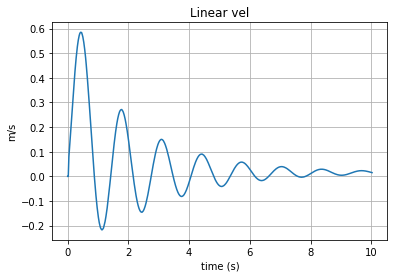

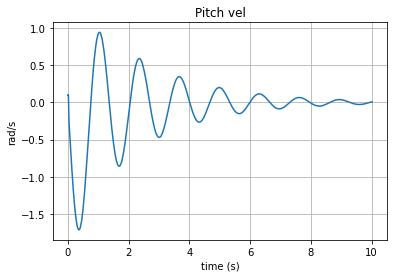

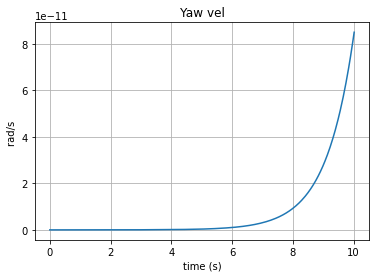

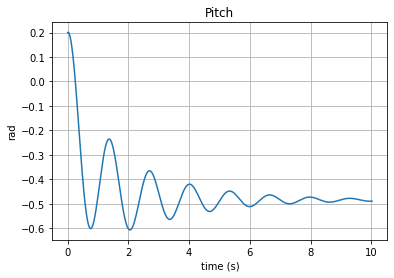

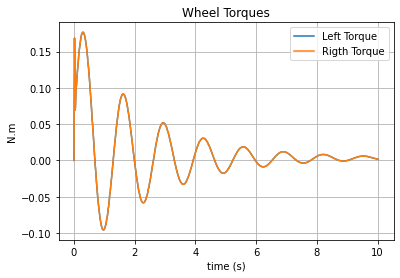

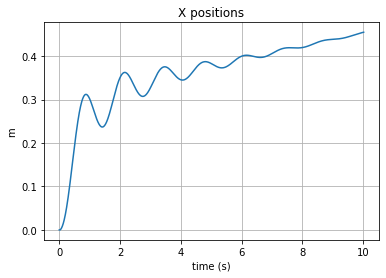

In [147]:
fig1 = plt.figure()
plt.plot(time_history,history[0,:])
plt.title("Linear vel")
plt.xlabel("time (s)")
plt.ylabel("m/s")
plt.grid()

fig2 = plt.figure()
plt.plot(time_history,history[1,:])
plt.title("Pitch vel")
plt.xlabel("time (s)")
plt.ylabel("rad/s")
plt.grid()

fig3 = plt.figure()
plt.plot(time_history,history[2,:])
plt.title("Yaw vel")
plt.xlabel("time (s)")
plt.ylabel("rad/s ")
plt.grid()

fig4 = plt.figure()
plt.plot(time_history,history[3,:])
plt.title("Pitch")
plt.xlabel("time (s)")
plt.ylabel("rad")
plt.grid()

fig5 = plt.figure()
plt.plot(time_history,input_history[0,:], label='Left Torque')
plt.plot(time_history,input_history[1,:], label='Rigth Torque')
plt.title("Wheel Torques")
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("N.m")
plt.grid()

fig7 = plt.figure()
plt.plot(time_history,x_pos)
plt.title("X positions")
plt.xlabel("time (s)")
plt.ylabel("m")
plt.grid()

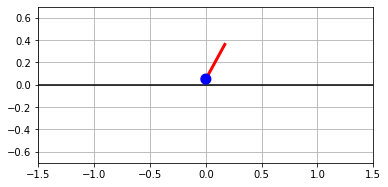

In [ ]:
#Generates an animation using Matplotlib

from matplotlib.patches import Circle
from matplotlib.animation import FuncAnimation

xlim = (-1.5,1.5)
ylim = (-0.7,0.7)

fig = plt.figure() #figsize=(8.3333, 7.25), dpi=72
ax = fig.add_subplot(111,xlim=xlim,ylim=ylim)
ax.set_aspect('equal')
ax.grid()

height = 0.354

ax.plot([xlim[0],xlim[1]],[0,0],'-k')         # Ground

pend_rod, = ax.plot([x_pos[0], x_pos[0]+height*np.math.sin(history[3,0])],[r_v[1],r_v[1] + height*np.math.cos(history[3,0])], 'r', lw=3)
pend_wheel = ax.add_patch(Circle((x_pos[0],r_v[1]), r_v[1], fc='b', zorder=3))

def init_anim():
  pend_rod, = ax.plot([x_pos[0], x_pos[0]+height*np.math.sin(history[3,0])],[r_v[1],r_v[1] + height*np.math.cos(history[3,0])], 'r', lw=3)
  pend_wheel = ax.add_patch(Circle((x_pos[0],r_v[1]), r_v[1], fc='b', zorder=3))
  return pend_rod, pend_wheel
  
def animate(i):
  xaxis = [x_pos[i], x_pos[i] + height*np.math.sin(history[3,i])]
  yaxis = [r_v[1], r_v[1] + height*np.math.cos(history[3,i])]
  
  pend_rod.set_data(xaxis,yaxis)
  pend_wheel.set_center((x_pos[i],r_v[1]))
  return pend_rod, pend_wheel

anim = FuncAnimation(fig, animate,frames=len(time_history),interval=200,blit=True)

In [ ]:
# anim.save("Gifs/test.gif", fps=36) #Generates a .gif for the animation